In [138]:
import pandas as pd
import numpy as np 
import pickle5
import matplotlib.pyplot as plt
import datetime
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.utils.display import display_loss_values
from sklearn.preprocessing import StandardScaler
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils import save_model, load_model
from pysurvival.utils.sklearn_adapter import sklearn_adapter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import auc
from sklearn.metrics import r2_score
from sklearn.utils import resample
from sklearn import metrics
from lifelines.utils import concordance_index as c_index

In [106]:
with open("../Data/Boulder/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head(3)

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


In [107]:
df.shape

(12711, 71)

### Remove events

In [108]:
names = df['Station_Name'].unique()

In [109]:
for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [110]:
df.shape

(12699, 71)

### Remove outliers
Use boxplot outlier definition

In [111]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [112]:
df.shape

(12075, 71)

### Focus stations

In [113]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']

df = df[df['Station_Name'].isin(station_subset)]

### Prepare data for SA

As we are doing SA we need a column which specifies if an event occured at the given time. As all data observations in the dataset are events it is a very simple procedure

In [114]:
df['event'] = np.ones(len(df))

**Add TOD features**

In [118]:
df['tod'] = df['hour_b'].apply(hour_label)

In [119]:
df = df[df['tod'] != 'Night']

### Adding dummies
We define `X`, the features, `T`, the time column and `E` the event columns. First though we need to dummify the categorical variables.

In [120]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','hour_b','Station_Name']

In [121]:
df = pd.get_dummies(df, columns=columns_categorical, drop_first=True)

## Modeling features

To make coding easier the names of the models are changed:
- M1: Baseline
- M5: Full

In [123]:
time_column = 'life_time'
event_column = 'event'

## M1
features1 = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
             'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
             'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
             'tod_Evening','tod_Midday', 'tod_Morning',
             'Station_Name_BOULDER / N BOULDER REC 1',
             'Station_Name_COMM VITALITY / 1000WALNUT',
             'Station_Name_COMM VITALITY / 1104 SPRUCE1'] # dow + tod

## M5
features5_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']
features5_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management'] # dow + agg. tod + lag + activ.

In [ ]:
def residual_plot(T_test, T_test_pred):
    residuals = T_test - T_test_pred # define residuals
    fig, axs = plt.subplots(2,2, figsize=(10,6))
    axs[0,0].scatter(np.arange(len(residuals)),residuals, marker='.', c='k', alpha=0.2)
    axs[0,0].set_xlabel("Index")
    axs[0,0].set_ylabel("Residual")
    axs[0,0].set_title("Residuals vs index")
    axs[0,1].scatter(T_test_pred,residuals, marker='.', c='k', alpha=0.2)
    axs[0,1].set_xlabel("Predicted")
    axs[0,1].set_ylabel("Residual")
    axs[0,1].set_title("Residuals vs fitted")
    axs[1,0].hist(residuals, bins=50, color='w', edgecolor='k')
    axs[1,0].set_title("Histogram of residuals")
    axs[1,0].set_xlabel("Residuals")
    axs[1,0].set_ylabel("Counts")
    axs[1,1].scatter(T_test,T_test_pred, color='k', alpha=0.2, marker='.')
    axs[1,1].set_title("Actual vs predicted")
    axs[1,1].set_xlabel("Actual")
    axs[1,1].set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()

In [128]:
## define grid for RandomizedsearchCV
## One layers
struc10 = [{'activation': 'ReLU', 'num_units': 16}]
struc11 = [{'activation': 'ReLU', 'num_units': 32}]
struc12 = [{'activation': 'ReLU', 'num_units': 64}]
struc13 = [{'activation': 'ReLU', 'num_units': 128}]
struc14 = [{'activation': 'ReLU', 'num_units': 264}]

## Two layers
struc20 = [{'activation': 'ReLU', 'num_units': 16},{'activation': 'ReLU', 'num_units': 16}]
struc21 = [{'activation': 'ReLU', 'num_units': 32},{'activation': 'ReLU', 'num_units': 32}]
struc22 = [{'activation': 'ReLU', 'num_units': 64},{'activation': 'ReLU', 'num_units': 64}]
struc23 = [{'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128}]
struc24 = [{'activation': 'ReLU', 'num_units': 264},{'activation': 'ReLU', 'num_units': 264}]

## Three layers
struc30 = [{'activation': 'ReLU', 'num_units': 16},{'activation': 'ReLU', 'num_units': 16},
           {'activation': 'ReLU', 'num_units': 16}]
struc31 = [{'activation': 'ReLU', 'num_units': 32},{'activation': 'ReLU', 'num_units': 32},
           {'activation': 'ReLU', 'num_units': 32}]
struc32 = [{'activation': 'ReLU', 'num_units': 64},{'activation': 'ReLU', 'num_units': 64}, 
           {'activation': 'ReLU', 'num_units': 64}]
struc33 = [{'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128},
           {'activation': 'ReLU', 'num_units': 128}]
struc34 = [{'activation': 'ReLU', 'num_units': 264},{'activation': 'ReLU', 'num_units': 264},
           {'activation': 'ReLU', 'num_units': 264}]

## Four layers
struc40 = [{'activation': 'ReLU', 'num_units': 16},{'activation': 'ReLU', 'num_units': 16},
           {'activation': 'ReLU', 'num_units': 16},{'activation': 'ReLU', 'num_units': 16}]
struc41 = [{'activation': 'ReLU', 'num_units': 32},{'activation': 'ReLU', 'num_units': 32},
           {'activation': 'ReLU', 'num_units': 32},{'activation': 'ReLU', 'num_units': 32}]
struc42 = [{'activation': 'ReLU', 'num_units': 64},{'activation': 'ReLU', 'num_units': 64}, 
           {'activation': 'ReLU', 'num_units': 64},{'activation': 'ReLU', 'num_units': 64}]
struc43 = [{'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128},
           {'activation': 'ReLU', 'num_units': 128},{'activation': 'ReLU', 'num_units': 128}]
struc44 = [{'activation': 'ReLU', 'num_units': 264},{'activation': 'ReLU', 'num_units': 264},
           {'activation': 'ReLU', 'num_units': 264},{'activation': 'ReLU', 'num_units': 264}]

## define grid
grid = {'lr':[0.0001,0.001,0.01,0.1], 'l2_reg':[0.0001,0.001,0.01,1,10], 'num_epochs':[10,100,500,1000],
        'structure':[struc10,struc11,struc12,struc13,struc14,struc20,struc21,struc22,struc23,struc24,
                     struc30,struc31,struc32,struc33,struc34,struc40,struc41,struc42,struc43,struc44],
       'dropout':[0.1,0.25,0.5]}

In [129]:
# dictionary to save results in 
results = {}


split = 0.8
b_params = {}

#### DeepSurv - Model 1

Training M1
Parameter tuning done.
Parameters: {'structure': [{'activation': 'ReLU', 'num_units': 128}, {'activation': 'ReLU', 'num_units': 128}], 'num_epochs': 100, 'lr': 0.01, 'l2_reg': 0.01, 'dropout': 0.1}
Final model fitted.
Model tested


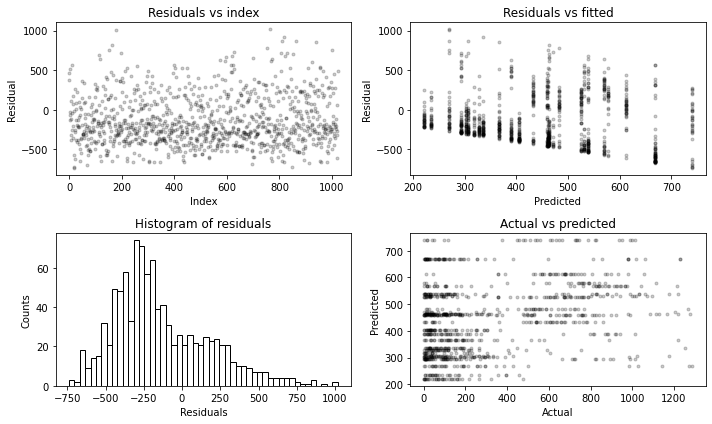

In [130]:
results['M1'] = {}
print("Training M1")
# define data
X = df[features1]
X_train, X_test = np.split(X, [int(split * len(df))])
T_train, T_test = np.split(df[time_column], [int(split * len(df))])
E_train, E_test = np.split(df[event_column], [int(split * len(df))])
y_train = pd.concat((pd.DataFrame(T_train), pd.DataFrame(E_train)), axis=1)
y_test = pd.concat((pd.DataFrame(T_test), pd.DataFrame(E_test)), axis=1)

### Find most optimal parameters for every station
## sklearn adapter
dsSklearn = sklearn_adapter(NonLinearCoxPHModel, time_col=time_column, event_col=event_column,
                          predict_method="predict_survival", scoring_method=concordance_index)
dsSkl = dsSklearn()
reg = RandomizedSearchCV(dsSkl, grid, random_state=42, n_iter=50, cv=5) # if n_iter = 100 it will train 100 models.
reg.fit(X_train,y_train, verbose=False, batch_normalization=False)#, num_epochs=100)
print("Parameter tuning done.")

## Params
params = reg.best_params_
print("Parameters:", params)

## Fit model
reg = NonLinearCoxPHModel(structure=params['structure'])
reg.fit(X_train, T_train, E_train, lr=params['lr'], l2_reg=params['l2_reg'], 
        batch_normalization=False, verbose=False, num_epochs=params['num_epochs'],
        dropout=params['dropout'])
print("Final model fitted.")

## Point predictions
T_test_pred, T_train_pred = point_pred(reg, X_test, X_train)

## Test model
c_test = c_index(T_test, T_test_pred)
c_train = c_index(T_train, T_train_pred)
print("Model tested")

## Get metrics
MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(T_test,T_test_pred)
MAE_train, RMSE_train, MSE_train, MAPE_train, NRMSE_train = test_model(T_train,T_train_pred)    

# plot residuals
residual_plot(T_test, T_test_pred)

## Save results
results['M1'] = {'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,
                  'MAE_train': MAE_train,'MAE_test':MAE_test,
                  'R2_test':r2_score(T_test,T_test_pred), 
                  'R2_train':r2_score(T_train,T_train_pred),
                  'MAPE_test':MAPE_test,'MAPE_train':MAPE_train,
                  'NRMSE_test':NRMSE_test,'NRMSE_train':NRMSE_train,
                  'c-train':c_train,'c-test':c_test}

In [131]:
params

{'structure': [{'activation': 'ReLU', 'num_units': 128},
  {'activation': 'ReLU', 'num_units': 128}],
 'num_epochs': 100,
 'lr': 0.01,
 'l2_reg': 0.01,
 'dropout': 0.1}

#### DeepSurv - M5

Training M5


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


Parameter tuning done.
Parameters: {'structure': [{'activation': 'ReLU', 'num_units': 32}, {'activation': 'ReLU', 'num_units': 32}], 'num_epochs': 100, 'lr': 0.01, 'l2_reg': 10, 'dropout': 0.25}
Final model fitted.
Model tested


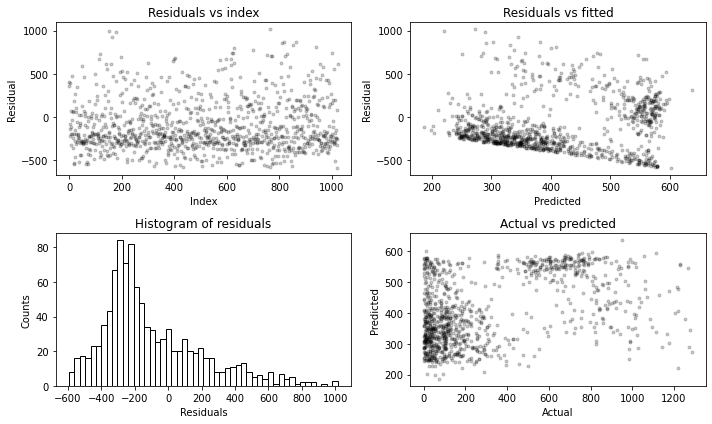

In [132]:
results['M5'] = {}
print("Training M5")
# define data
X = df[features5_cat+features5_con]
X_train, X_test = np.split(X, [int(split * len(df))])
scaler = StandardScaler()
X_train[features5_con] = scaler.fit_transform(X_train[features5_con])
X_test[features5_con] = scaler.fit_transform(X_test[features5_con])
T_train, T_test = np.split(df[time_column], [int(split * len(df))])
E_train, E_test = np.split(df[event_column], [int(split * len(df))])
y_train = pd.concat((pd.DataFrame(T_train), pd.DataFrame(E_train)), axis=1)
y_test = pd.concat((pd.DataFrame(T_test), pd.DataFrame(E_test)), axis=1)

### Find most optimal parameters for every station
## sklearn adapter
dsSklearn = sklearn_adapter(NonLinearCoxPHModel, time_col=time_column, event_col=event_column,
                          predict_method="predict_survival", scoring_method=concordance_index)
dsSkl = dsSklearn()
reg = RandomizedSearchCV(dsSkl, grid, random_state=42, n_iter=50, cv=5) # if n_iter = 100 it will train 100 models.
reg.fit(X_train,y_train, verbose=False, batch_normalization=False)
print("Parameter tuning done.")

## Params
params = reg.best_params_
print("Parameters:", params)

## Fit model
reg = NonLinearCoxPHModel(structure=params['structure'])
reg.fit(X_train, T_train, E_train, lr=params['lr'], l2_reg=params['l2_reg'],
        batch_normalization=False, verbose=False, num_epochs=params['num_epochs'],
        dropout=params['dropout'])
print("Final model fitted.")

## Point predictions
T_test_pred, T_train_pred = point_pred(reg, X_test, X_train)

## Test model
c_test = c_index(T_test, T_test_pred)
c_train = c_index(T_train, T_train_pred)
print("Model tested")

## Get metrics
MAE_test, RMSE_test, MSE_test, MAPE_test, NRMSE_test = test_model(T_test,T_test_pred)
MAE_train, RMSE_train, MSE_train, MAPE_train, NRMSE_train = test_model(T_train,T_train_pred)    

# plot residuals
residual_plot(T_test, T_test_pred)

## Save results
results['M5'] = {'RMSE_train':RMSE_train,'RMSE_test':RMSE_test,
                  'MAE_train': MAE_train,'MAE_test':MAE_test,
                  'R2_test':r2_score(T_test,T_test_pred), 
                  'R2_train':r2_score(T_train,T_train_pred),
                  'MAPE_test':MAPE_test,'MAPE_train':MAPE_train,
                  'NRMSE_test':NRMSE_test,'NRMSE_train':NRMSE_train,
                  'c-train':c_train,'c-test':c_test}

### Results

In [134]:
for key in results.keys():
    r = results[key]
    print("------- {} -------".format(key))
    print("Test:  C-index: {} R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r['c-test'],2),
                                                                        round(r['R2_test'],2),
                                                                        round(r['RMSE_test'],0),
                                                                        round(r['MAE_test'],0),
                                                                        round(r['MAPE_test'],0)))
    
    print("Train:  C-index: {}  R2: {} RMSE: {} MAE: {} MAPE: {}".format(round(r['c-train'],2),
                                                                        round(r['R2_train'],2),
                                                                        round(r['RMSE_train'],0),
                                                                        round(r['MAE_train'],0),
                                                                        round(r['MAPE_train'],0)))

------- M1 -------
Test:  C-index: 0.59 R2: -0.08 RMSE: 339.0 MAE: 291.0 MAPE: 1991.0
Train:  C-index: 0.64  R2: 0.2 RMSE: 468.0 MAE: 368.0 MAPE: 1472.0
------- M5 -------
Test:  C-index: 0.62 R2: 0.08 RMSE: 314.0 MAE: 267.0 MAPE: 1826.0
Train:  C-index: 0.66  R2: 0.22 RMSE: 462.0 MAE: 361.0 MAPE: 1450.0
